In [45]:
import sqlite3
import pandas as pd
import numpy as np
#take SQL query and return pandas dataframe
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [46]:
#execute SQL command 
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [47]:
#return list of tables and views in database
def show_tables():
    q= '''
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [48]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [49]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url='https://s3.amazonaws.com/dq-content/280/chinook-schema.svg')


# count the number of track sold in USA per genre

In [50]:
number_of_track_sold_genre = '''
WITH usa_tracks AS (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country='USA'
    )
SELECT g.name AS 'genre name', 
    COUNT(ut.invoice_line_id) as number_track_sold
FROM usa_tracks ut
INNER JOIN track t ON ut.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC;
'''

run_query(number_of_track_sold_genre)


,genre name,number_track_sold
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Latin,22
7,Pop,22
8,Hip Hop/Rap,20
9,Jazz,14


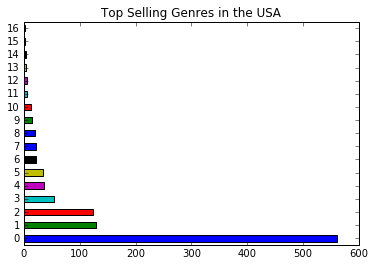

In [51]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
sold_per_genre = run_query(number_of_track_sold_genre)
sold_per_genre["number_track_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 600),
)

plt.ylabel('')

# sales rep performance

In [73]:
employee_sales_performance = '''
WITH customer_sales_rep AS(
     SELECT i.customer_id, c.support_rep_id, SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    ),
    employee_supervisor AS(
    SELECT e.*, e1.first_name || " " || e1.last_name supervisor_name
    FROM employee e
    INNER JOIN employee e1 ON e.reports_to = e1.employee_id
    )

SELECT
    es.first_name || " " || es.last_name employee, es.supervisor_name,
    SUM(csr.total) total_sales
FROM customer_sales_rep csr
INNER JOIN employee_supervisor es ON es.employee_id = csr.support_rep_id
GROUP BY 1;
'''


run_query(employee_sales_performance)


,employee,supervisor_name,total_sales
0,Jane Peacock,Nancy Edwards,1731.51
1,Margaret Park,Nancy Edwards,1584.00
2,Steve Johnson,Nancy Edwards,1393.92


testing 'with' statements

In [75]:
test ='''SELECT e.*, e1.first_name || " " || e1.last_name supervisor_name
    FROM employee e
    INNER JOIN employee e1 ON e.reports_to = e1.employee_id
    LIMIT 5'''

run_query(test)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email,supervisor_name
0,2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com,Andrew Adams
1,3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com,Nancy Edwards
2,4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com,Nancy Edwards
3,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com,Nancy Edwards
4,6,Mitchell,Michael,IT Manager,1,1973-07-01 00:00:00,2016-10-17 00:00:00,5827 Bowness Road NW,Calgary,AB,Canada,T3B 0C5,+1 (403) 246-9887,+1 (403) 246-9899,michael@chinookcorp.com,Andrew Adams


In [74]:
test ='''SELECT i.customer_id, c.support_rep_id, SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
     LIMIT 5'''

run_query(test)

,customer_id,support_rep_id,total
0,1,3,108.90
1,2,5,82.17
2,3,3,99.99
3,4,4,72.27
4,5,4,144.54


#  purchases from different countries

Where a country has only one customer, collect them into an "Other" group.
The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

In [78]:
purchase_per_country = '''
WITH country_or_other AS(
     SELECT
       CASE
           WHEN (SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id, il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT country, COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
FROM country_or_other
GROUP BY country
ORDER BY sort ASC, total_sales DESC
;

'''
run_query(purchase_per_country)

,country,customers,total_sales,customer_lifetime_value,average_order,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other,15,1094.94,72.996000,7.448571,1


In [77]:
test = '''SELECT
       CASE
           WHEN (SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id, il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     LIMIT 5'''

run_query(test)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1


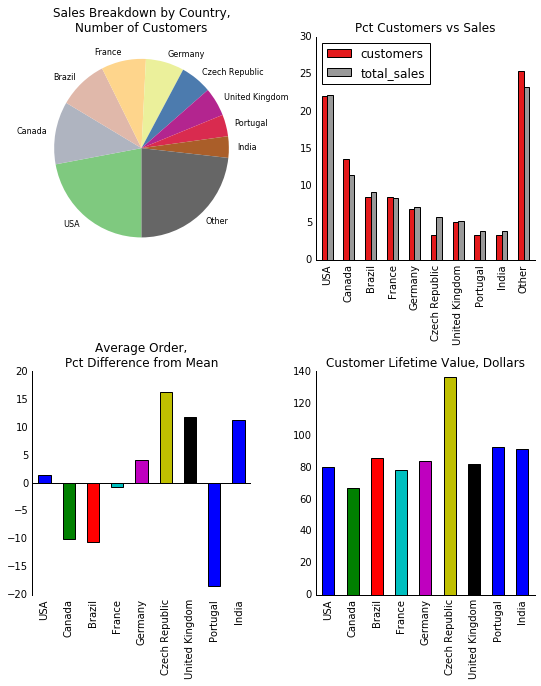

In [84]:
country = run_query(purchase_per_country)
country.set_index("country", drop=True, inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()